# Predicting Evergreeness of Content with Decision Trees and Random Forests

## Load the StumbleUpon dataset

We will be using a dataset from StumbleUpon, a service that recommends webpages to users based on their interests.  They like to recommend “evergreen” sites, sites that are always relevant.  This usually means websites that avoid topical content and focus on recipes, how-to guides, art projects, etc.  We want to determine important characteristics for “evergreen” websites. Follow these prompts to get started:

In [1]:
import pandas as pd
import json
%matplotlib inline

data = pd.read_csv("stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.map(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.map(lambda x: json.loads(x).get('body', ''))
data.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,24,0,5424,170,8,0.152941,0.079130,0,IBM Sees Holographic Calls Air Breathing Batte...,A sign stands outside the International Busine...
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,40,0,4973,187,9,0.181818,0.125448,1,The Fully Electronic Futuristic Starting Gun T...,And that can be carried on a plane without the...
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,55,0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight th...,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,24,0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot...
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,14,0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed...,Jersey sales is a curious business Whether you...


In [2]:
data.boilerplate.loc[0]

'{"title":"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries","body":"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 D image of anyone who calls and your laptop will be powered by kinetic energy At least that s what International Business Machines Corp sees in its crystal ball The predictions are part of an annual tradition for the Armonk New York based company which surveys its 3 000 researchers to find five ideas expected to take root in the next five years IBM the world s largest provider of computer services looks to Silicon Valley for input gleaning many ideas from its Almaden research center in San Jose

In [3]:
data.embed_ratio

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.004065
12      0.000000
13     -1.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      0.000000
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000236
24     -1.000000
25      0.010638
26      0.000000
27      0.000000
28      0.000000
29      0.000000
          ...   
7365    0.000000
7366    0.000000
7367   -1.000000
7368    0.000000
7369    0.001294
7370    0.000000
7371    0.004808
7372    0.000000
7373    0.000000
7374    0.000000
7375    0.000000
7376    0.000000
7377    0.000000
7378    0.000000
7379    0.000000
7380   -1.000000
7381    0.019231
7382    0.000000
7383   -1.000000
7384    0.000000
7385    0.000000
7386    0.000000
7387    0.000000
7388    0.000000
7389    0.000000
7390    0.000000
7391    0.000000
7392    0.0000

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at www.alchemyapi.com)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at www.alchemyapi.com)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an <a> with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 <a> 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

In [4]:
data[['url', 'label']].head(20)

,url,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,0
1,http://www.popsci.com/technology/article/2012-...,1
2,http://www.menshealth.com/health/flu-fighting-...,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,1
4,http://bleacherreport.com/articles/1205138-the...,0
5,http://www.conveniencemedical.com/genital-herp...,0
6,http://gofashionlane.blogspot.tw/2012/06/ameri...,1
7,http://www.insidershealth.com/article/racing_f...,0
8,http://www.valetmag.com/the-handbook/features/...,1
9,http://www.howsweeteats.com/2010/03/24/cookies...,1


### Exercises to Get Started

> ### Exercise: 1. In a group: Brainstorm 3 - 5 features you could develop that would be useful for predicting evergreen websites.
 ###  Exercise: 2. After looking at the dataset, can you model or quantify any of the characteristics you wanted?
- I.E. If you believe high-image content websites are likely to be evergreen, how can you build a feature that represents that?
- I.E. If you believe weather content is likely NOT to be evergreen, how might you build a feature that represents that?

### Split up and develop 1-3 of the those features independently.

> ### Exercise: 3. Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

is_news
1    2353
?    1443
dtype: int64

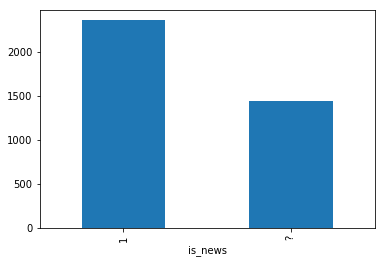

In [5]:
# ... #
data[data['label']==1][['label','is_news']].groupby('is_news').size().plot(kind='bar')
data[data['label']==1][['label','is_news']].groupby('is_news').size()

          not_evergeen  evergreen
news          0.483084   0.516916
not_news      0.492438   0.507562


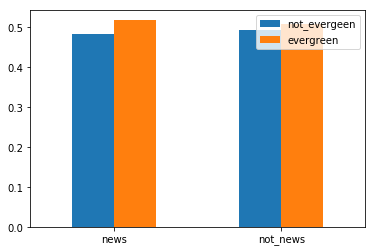

In [6]:
data_2 = pd.crosstab(columns=data['label'],index=data['is_news'],normalize='index')
data_2.index = ['news','not_news'] 
data_2.columns = ['not_evergeen','evergreen']
print(data_2)
data_2.plot(kind='bar',rot=0)

#evergreen goes on top because it is the target

In [7]:
import seaborn as sb

data.groupby(['is_news'])[['label']].mean()

,label
is_news,
1,0.516916
?,0.507562


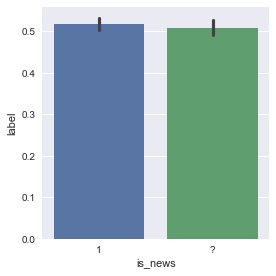

In [8]:
sb.factorplot(x='is_news'
             ,y='label'
             ,kind='bar'
             ,data=data)

> ### Exercise: 4. Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

In [9]:
data_3 = pd.crosstab(columns=data['label'],index=data['alchemy_category'],normalize='index')
data_3.columns = ['not_evergreen','evergreen']
data_3

,not_evergreen,evergreen
alchemy_category,,
?,0.497865,0.502135
arts_entertainment,0.628055,0.371945
business,0.288636,0.711364
computer_internet,0.753378,0.246622
culture_politics,0.542274,0.457726
gaming,0.631579,0.368421
health,0.426877,0.573123
law_crime,0.580645,0.419355
recreation,0.315704,0.684296


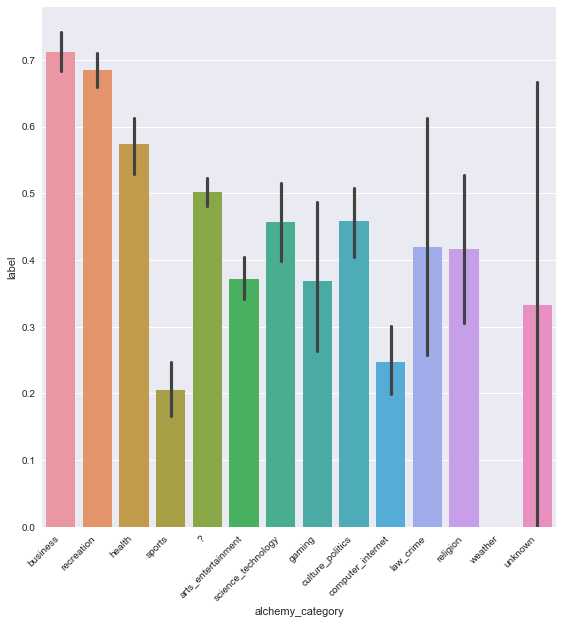

In [10]:
p = sb.factorplot(x='alchemy_category'
                 ,y='label'
                 ,kind='bar'
                 ,data=data
                 ,size=8)

p.set_xticklabels(rotation=45,horizontalalignment='right')

> ### Exercise: 5. How many articles are there per category?

In [11]:
data['alchemy_category'].value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

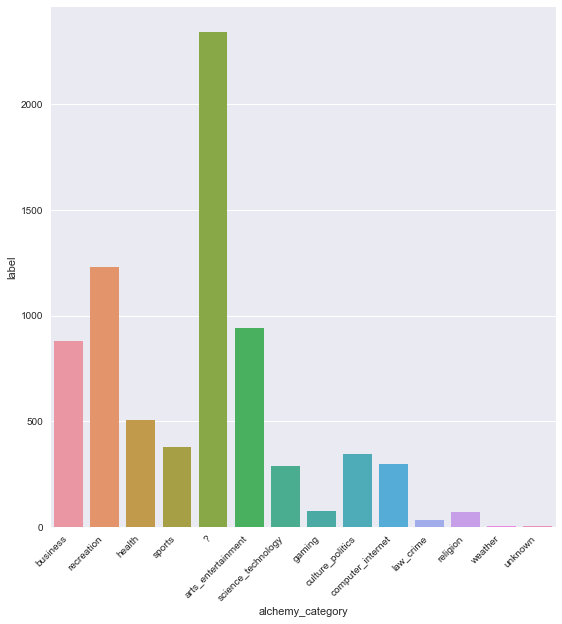

In [12]:
p = sb.factorplot(x='alchemy_category'
                 ,y='label'
                 ,kind='bar'
                 ,data=data
                 ,size=8
                 ,estimator=len)

p.set_xticklabels(rotation=45,horizontalalignment='right')

> #### Let's try extracting some of the text content.
> ### Exercise: 6. Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [13]:
from collections import Counter

def has_recipe(text_in):
    try:
        if 'recipe' in str(text_in).lower():
            return 1
        else:
            return 0
    except:
        return 0

data['recipe'] = data['title'].map(has_recipe) #map is apply a function to every element and will return a value
data['recipe']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      1
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
7365    0
7366    0
7367    0
7368    0
7369    0
7370    0
7371    1
7372    0
7373    0
7374    0
7375    0
7376    1
7377    0
7378    1
7379    0
7380    1
7381    0
7382    0
7383    0
7384    0
7385    0
7386    0
7387    0
7388    0
7389    0
7390    0
7391    0
7392    0
7393    0
7394    0
Name: recipe, Length: 7395, dtype: int64

In [14]:
data['recipe'] = data['title'].str.contains('recipe')

In [15]:
print(Counter(data['recipe']))

Counter({False: 7030, True: 353, None: 12})


###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

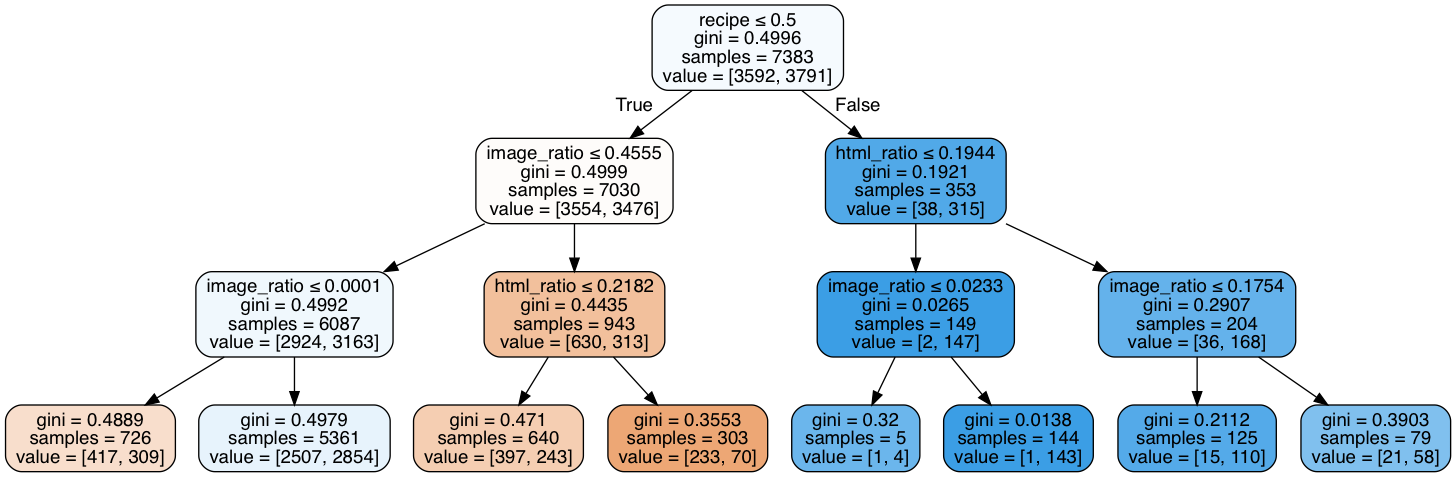

In [34]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3)

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
def build_tree_image(model,dot_data):
    export_graphviz(model, 
                out_file = dot_data,  
                filled = True, 
                rounded = True,
                special_characters = True,
                feature_names = X.columns)  

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return graph

graph = build_tree_image(model,dot_data)
Image(graph.create_png())


#from sklearn.tree import export_graphviz
#from os import system 
#def build_tree_image(model):
#    dotfile = open("tree.dot", 'w')
#    export_graphviz(model,
#                              out_file = dotfile,
#                              feature_names = X.columns)
#    dotfile.close()
#    system("dot -Tpng tree.dot -o tree.png")
    
#build_tree_image(model)
#labels = model.predict(X)
#labels

#labels = model.predict(X)
#labels

In [35]:
labels = model.predict(X)
labels
model.n_features_    
model.predict_proba(X[(X['image_ratio']>0.4555) & (X['recipe']==0)])
#model.predict(X[(X['image_ratio']>0.4555) & (X['recipe']==0)])

array([[ 0.6203125,  0.3796875],
       [ 0.7689769,  0.2310231],
       [ 0.6203125,  0.3796875],
       ..., 
       [ 0.6203125,  0.3796875],
       [ 0.7689769,  0.2310231],
       [ 0.6203125,  0.3796875]])

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [36]:
data.is_news.replace('?',0,inplace=True)

In [39]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model,X,y,scoring='roc_auc',cv=5)
print('CV AUC{}, Average AUC {}'.format(scores,scores.mean()))

CV AUC[ 0.53683659  0.54809982  0.54307351  0.53214     0.54595733], Average AUC 0.5412214494573562


In [40]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()

X = data[['image_ratio','html_ratio','recipe','label']].dropna()
y = X['label']
X.drop('label',axis=1,inplace=True)

model.fit(X,y)

for scoring in ['roc_auc','accuracy','recall','precision']:
    scores = cross_val_score(model,X,y,scoring=scoring,cv=5)
    print(scoring,':')
    print(scores)

roc_auc :
[ 0.53540912  0.54162278  0.5354749   0.52393228  0.5650517 ]
accuracy :
[ 0.5338295   0.52809749  0.55149051  0.53387534  0.56097561]
recall :
[ 0.54677207  0.54221636  0.5646438   0.52902375  0.57124011]
precision :
[ 0.54812834  0.54907162  0.55297158  0.55074425  0.57783641]


In [38]:
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()

X = data[['image_ratio','html_ratio','recipe','is_news','label']].dropna()
y = X['label']
X.drop('label',axis=1,inplace=True)

model.fit(X,y)

for scoring in ['roc_auc','accuracy','recall','precision']:
    scores = cross_val_score(model,X,y,scoring=scoring,cv=5)
    print(scoring,':')
    print(scores)

roc_auc :
[ 0.53808081  0.5406604   0.54853889  0.53071049  0.55116088]
accuracy :
[ 0.53044655  0.5423155   0.54132791  0.53252033  0.55149051]
recall :
[ 0.54545455  0.53298153  0.56332454  0.55013193  0.56332454]
precision :
[ 0.54709677  0.55135135  0.55832241  0.54437086  0.56191744]


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

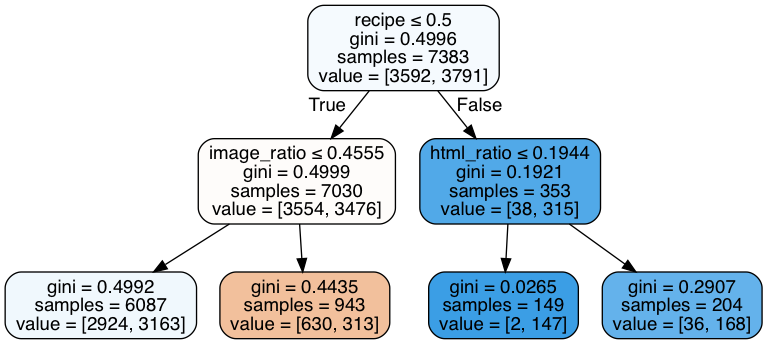

In [41]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
#build_tree_image(model)

dot_data = StringIO()
graph = build_tree_image(model,dot_data)
Image(graph.create_png())

In [43]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier()
params = {'max_depth': range(1,11),
          'min_samples_leaf': range(1,11)}
gs = GridSearchCV(model,param_grid=params,scoring='roc_auc',cv=5)
gs.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 11), 'min_samples_leaf': range(1, 11)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [44]:
print(gs.best_score_)
print(gs.best_params_)

0.611860682154
{'max_depth': 6, 'min_samples_leaf': 4}


 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [45]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20) #build 20 trees
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Demo: Extracting importance of features

In [47]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

# feature importances: how much did the feature help to gain information? [information gain]
# i.e. higher is more important
# measured as the difference between the gini/entropy scores of the node which includes the feature and its child node

,Features,Importance Score
1,html_ratio,0.529706
0,image_ratio,0.439544
2,recipe,0.030750


 ### Exercise: Evaluate the Random Forest model using cross-validation; increase the number of estimators and view how that improves predictive performance.

In [50]:
scores = cross_val_score(model,X,y,scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores,scores.mean()))

for n_trees in range(1,100,10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model,X,y,scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees,scores,scores.mean()))

CV AUC [ 0.56233424  0.58308284  0.57806134], Average AUC 0.5744928092351547
n trees: 1, CV AUC [ 0.53073556  0.53690694  0.5329942 ], Average AUC 0.5335455693365304
n trees: 11, CV AUC [ 0.56256769  0.58320313  0.57672553], Average AUC 0.5741654494225981
n trees: 21, CV AUC [ 0.56396572  0.58120843  0.58135838], Average AUC 0.5755108440304854
n trees: 31, CV AUC [ 0.56294675  0.59071565  0.58059671], Average AUC 0.578086370456835
n trees: 41, CV AUC [ 0.56862968  0.5852854   0.58089139], Average AUC 0.5782688258722625
n trees: 51, CV AUC [ 0.56540238  0.59078901  0.58790914], Average AUC 0.5813668441987486
n trees: 61, CV AUC [ 0.57093805  0.59215616  0.58207772], Average AUC 0.581723974435486
n trees: 71, CV AUC [ 0.56725344  0.58183929  0.58021902], Average AUC 0.5764372503476943
n trees: 81, CV AUC [ 0.56853888  0.58505011  0.58233404], Average AUC 0.5786410075605458
n trees: 91, CV AUC [ 0.56757934  0.59144102  0.58499773], Average AUC 0.5813393632632211


##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [57]:
from sklearn import grid_search, cross_validation

gs = grid_search.GridSearchCV(
    estimator=RandomForestClassifier()
    ,param_grid={'n_estimators': [i for i in range(1,40,10)]
                 ,'min_samples_leaf': [i for i in range(1,5)]
                 ,'criterion': ['gini','entropy']}
    ,cv=cross_validation.KFold(n=len(X),n_folds=10)
    ,scoring='roc_auc')
gs.fit(X,y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=7383, n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 11, 21, 31], 'min_samples_leaf': [1, 2, 3, 4], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [87]:
print(gs.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=31, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [86]:
gs.grid_scores_

[mean: 0.52798, std: 0.01456, params: {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 1},
 mean: 0.56804, std: 0.01904, params: {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 11},
 mean: 0.57564, std: 0.01772, params: {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 21},
 mean: 0.57802, std: 0.01220, params: {'criterion': 'gini', 'min_samples_leaf': 1, 'n_estimators': 31},
 mean: 0.54659, std: 0.01528, params: {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 1},
 mean: 0.56938, std: 0.01796, params: {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 11},
 mean: 0.57228, std: 0.01059, params: {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 21},
 mean: 0.57906, std: 0.01668, params: {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 31},
 mean: 0.55113, std: 0.01686, params: {'criterion': 'gini', 'min_samples_leaf': 3, 'n_estimators': 1},
 mean: 0.57895, std: 0.01165, params: {'criterion': 'gini', 'min_sa

In [60]:
data.columns

Index(['url', 'urlid', 'boilerplate', 'alchemy_category',
       'alchemy_category_score', 'avglinksize', 'commonlinkratio_1',
       'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
       'compression_ratio', 'embed_ratio', 'framebased', 'frameTagRatio',
       'hasDomainLink', 'html_ratio', 'image_ratio', 'is_news',
       'lengthyLinkDomain', 'linkwordscore', 'news_front_page',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'label', 'title',
       'body', 'recipe'],
      dtype='object')

In [66]:
X = data[['image_ratio'
          ,'html_ratio'
          ,'recipe'
          ,'label'
          ,'linkwordscore'
          ,'numwords_in_url'
          ,'spelling_errors_ratio']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

model = RandomForestClassifier(n_estimators = 20)
model.fit(X, y)

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
1,html_ratio,0.234381
5,spelling_errors_ratio,0.220947
0,image_ratio,0.213956
3,linkwordscore,0.188828
4,numwords_in_url,0.112045


In [70]:
def has_best_or_worst(text_in):
    try:
        if 'best' in str(text_in).lower():
            return 1
        elif 'worst' in str(text_in).lower():
            return 1
        else:
            return 0
    except:
        return 0

data['best_or_worst'] = data['title'].map(has_best_or_worst) 

print(Counter(data['best_or_worst']))

Counter({0: 7174, 1: 221})


In [73]:
X = data[['image_ratio'
          ,'html_ratio'
          ,'best_or_worst'
          ,'label'
          ,'linkwordscore'
          ,'numwords_in_url'
          ,'spelling_errors_ratio']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

model = RandomForestClassifier(n_estimators = 20)
model.fit(X, y)

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
1,html_ratio,0.241719
5,spelling_errors_ratio,0.223554
0,image_ratio,0.217566
3,linkwordscore,0.198524
4,numwords_in_url,0.110687
2,best_or_worst,0.007951


In [75]:
def has_food(text_in):
    try:
        if 'food' in str(text_in).lower():
            return 1
        else:
            return 0
    except:
        return 0

data['food'] = data['title'].map(has_food) 

print(Counter(data['food']))

Counter({0: 6984, 1: 411})


In [76]:
X = data[['image_ratio'
          ,'html_ratio'
          ,'best_or_worst'
          ,'label'
          ,'linkwordscore'
          ,'numwords_in_url'
          ,'spelling_errors_ratio'
          ,'food'
          ,'recipe']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

model = RandomForestClassifier(n_estimators = 20)
model.fit(X, y)

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df

,Features,Importance Score
1,html_ratio,0.223218
5,spelling_errors_ratio,0.215835
0,image_ratio,0.204779
3,linkwordscore,0.196296
4,numwords_in_url,0.102938
7,recipe,0.026660
6,food,0.023087
2,best_or_worst,0.007187


In [81]:
def has_recreation(text_in):
    try:
        if 'recreation' in str(text_in).lower():
            return 1
        else:
            return 0
    except:
        return 0

data['recreation'] = data['alchemy_category'].map(has_recreation) 

print(Counter(data['recreation']))

Counter({0: 6166, 1: 1229})


In [98]:
X = data[['image_ratio'
          ,'html_ratio'
          ,'best_or_worst'
          ,'label'
          ,'linkwordscore'
          ,'numwords_in_url'
          ,'spelling_errors_ratio'
          ,'food'
          ,'recipe'
          ,'recreation']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

model = RandomForestClassifier(n_estimators = 20)
model.fit(X, y)

features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

scores = cross_val_score(model,X,y,scoring='roc_auc')

print(features_df)
print('\n')
print('CV AUC {}, Average AUC {}'.format(scores,scores.mean()))

                Features  Importance Score
1             html_ratio          0.216978
5  spelling_errors_ratio          0.205516
0            image_ratio          0.203243
3          linkwordscore          0.187631
4        numwords_in_url          0.106890
7                 recipe          0.028109
6                   food          0.022439
8             recreation          0.021442
2          best_or_worst          0.007751


CV AUC [ 0.69208339  0.68751785  0.67411866], Average AUC 0.6845732973930067


In [100]:
X = data[['image_ratio'
          ,'html_ratio'
          ,'best_or_worst'
          ,'label'
          ,'linkwordscore'
          ,'numwords_in_url'
          ,'spelling_errors_ratio'
          ,'food'
          ,'recipe'
          ,'recreation']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

model = RandomForestClassifier(n_estimators = 20)
model.fit(X, y)

features = X.columns
feature_importances = model.feature_importances_

gs = grid_search.GridSearchCV(
    estimator=RandomForestClassifier()
    ,param_grid={'n_estimators': [i for i in range(1,40,10)]
                 ,'min_samples_leaf': [i for i in range(1,5)]
                 ,'criterion': ['gini','entropy']}
    ,cv=cross_validation.KFold(n=len(X),n_folds=10)
    ,scoring='roc_auc')
gs.fit(X,y)

feature_importances = gs.best_estimator_.feature_importances_
features_df = pd.DataFrame({'Features':features,'Importance Score': feature_importances})
features_df.sort_values('Importance Score',inplace=True,ascending=False)
features_df

,Features,Importance Score
1,html_ratio,0.204280
0,image_ratio,0.203985
5,spelling_errors_ratio,0.202136
3,linkwordscore,0.184001
4,numwords_in_url,0.105208
7,recipe,0.038866
8,recreation,0.030340
6,food,0.027915
2,best_or_worst,0.003270
